# LSTM

## [1] 데이터 로딩
---

In [283]:
# 모듈 로딩
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl

mpl.rc('font',family='Malgun Gothic')

In [284]:
# data ,target 데이터 불러오기
data = pd.read_csv('./data_final.csv',index_col=0)
target = pd.read_csv('./target.csv')

# 민수용, 산업용
target_c = target['CIVIL']
target_i = target['IND']

## [2] 데이터 시각화
---

Text(0, 0.5, 'gas')

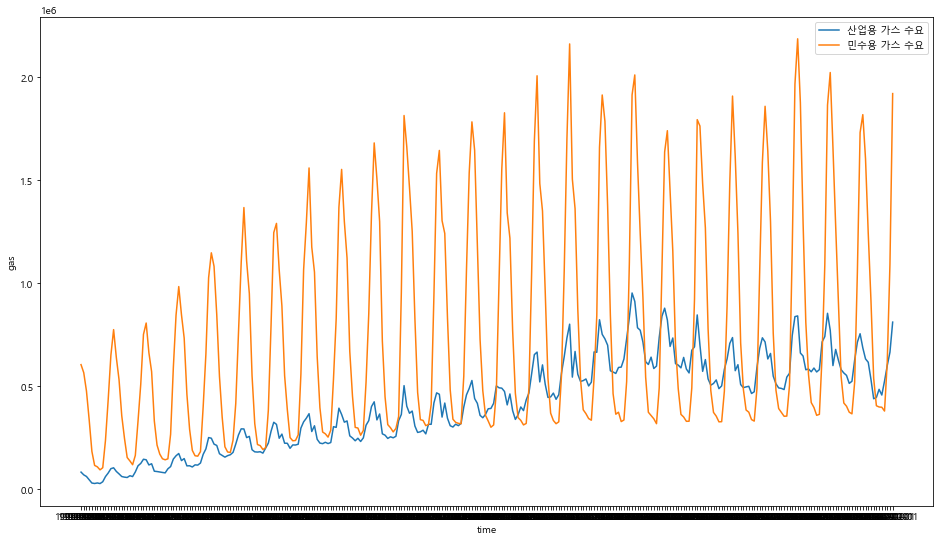

In [285]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=target['IND'], x=data['YEAR'], label='산업용 가스 수요')
sns.lineplot(y=target['CIVIL'], x=data['YEAR'], label ='민수용 가스 수요')
plt.legend()
plt.xlabel('time')
plt.ylabel('gas')

## [3] 데이터 전처리
---

In [286]:
data.iloc[:,1:].columns

Index(['AT', 'LT', 'HT', 'CAP_TEMP_EF', 'DONGNAM_TEMP_EF', 'DAEGYUNG_TEMP_EF',
       'CHOONG_TEMP_EF', 'HONAM_TEMP_EF', 'MEAN_TEMP_EF', 'POWER_WATER',
       'POWER_FIRE', 'POWER_NUCLEAR', 'POWER_NAEYEON', 'POWER_GROUP',
       'POWER_TRANS', 'POWER_GAS', 'POWER_JUNG', 'POWER_MOO', 'POWER_YOU',
       'POWER_LNG', 'all', 'family', 'public', 'service', 'civil_sum',
       'argri_fishing', 'mining', 'manufact', 'ind_sum'],
      dtype='object')

In [287]:
# 데이터 정규화
from sklearn.preprocessing import MinMaxScaler

data.sort_index(ascending=False).reset_index(drop=True)
data_col = ['AT', 'LT', 'HT', 'CAP_TEMP_EF', 'DONGNAM_TEMP_EF', 'DAEGYUNG_TEMP_EF',
       'CHOONG_TEMP_EF', 'HONAM_TEMP_EF', 'MEAN_TEMP_EF', 'POWER_WATER',
       'POWER_FIRE', 'POWER_NUCLEAR', 'POWER_NAEYEON', 'POWER_GROUP',
       'POWER_TRANS', 'POWER_GAS', 'POWER_JUNG', 'POWER_MOO', 'POWER_YOU',
       'POWER_LNG', 'all', 'family', 'public', 'service', 'civil_sum',
       'argri_fishing', 'mining', 'manufact', 'ind_sum']

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.iloc[:,1:]) # YEAR 제외
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = data_col

data_scaled


,AT,LT,HT,CAP_TEMP_EF,DONGNAM_TEMP_EF,DAEGYUNG_TEMP_EF,CHOONG_TEMP_EF,HONAM_TEMP_EF,MEAN_TEMP_EF,POWER_WATER,...,POWER_LNG,all,family,public,service,civil_sum,argri_fishing,mining,manufact,ind_sum
0,0.119401,0.211867,0.059217,0.962362,0.843924,0.842862,0.836159,0.803336,0.897574,0.165935,...,0.385434,0.025200,0.047550,0.022943,0.024189,0.032655,0.008191,0.089819,0.057683,0.049688
1,0.120178,0.202764,0.092605,0.944191,0.823706,0.826438,0.819845,0.785243,0.879284,0.159738,...,0.385434,0.000000,0.043302,0.023558,0.018796,0.027925,0.024838,0.038433,0.005028,0.002813
2,0.154554,0.246586,0.091354,0.829553,0.614455,0.630423,0.613482,0.569850,0.717359,0.165656,...,0.385434,0.021377,0.004930,0.008597,0.000659,0.002479,0.036284,0.097338,0.084134,0.076453
3,0.187260,0.264731,0.145515,0.626857,0.378784,0.409702,0.337924,0.270990,0.482756,0.169633,...,0.385434,0.026404,0.017129,0.021931,0.008748,0.012953,0.002014,0.111380,0.085734,0.074844
4,0.231290,0.316306,0.172376,0.280936,0.298854,0.329730,0.236877,0.177441,0.256523,0.235305,...,0.385434,0.019440,0.000000,0.000000,0.000681,0.000000,0.008902,0.092618,0.085744,0.075281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1.000000,1.000000,0.996179,0.205006,0.031211,0.031220,0.027430,0.023181,0.105861,0.803492,...,0.189724,0.855630,0.764281,0.800154,0.800842,0.839172,0.737714,0.247074,0.856790,0.846251
296,0.810567,0.750738,0.836423,0.227114,0.180772,0.287526,0.149389,0.123916,0.189422,0.629421,...,0.068214,0.870602,0.841891,0.740578,0.761076,0.832501,0.803953,0.315869,0.891687,0.885004
297,0.604894,0.521640,0.643739,0.411108,0.294644,0.425918,0.316760,0.227973,0.350950,0.265176,...,0.018205,0.693669,0.505635,0.588249,0.590748,0.600022,0.564597,0.303253,0.806613,0.785020
298,0.421387,0.351787,0.532630,0.621352,0.429899,0.555267,0.482347,0.366024,0.532280,0.221027,...,0.159254,0.754595,0.542281,0.698444,0.636553,0.652586,0.832913,0.484946,0.849131,0.851057


## [4] 데이터셋 분리
---

In [288]:
# 과거 데이터 학습 함수
def make_dataset(data, label, window_size=6):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [289]:
TEST_SIZE = 60 # 테스트: 2020년(12개월) / 학습: 1996~2019(288개월)
WINDOW_SIZE = 6 # 학습시킬 과거 개월 단위(12개월)

x_train = data_scaled[:-TEST_SIZE]
x_test = data_scaled[-TEST_SIZE:]

y_train = target_i[:-TEST_SIZE]
y_test = target_i[-TEST_SIZE:]

In [290]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((240, 29), (60, 29), (240,), (60,))

In [291]:
from sklearn.model_selection import train_test_split

train_feature, train_label = make_dataset(x_train, y_train, 6)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((187, 6, 29), (47, 6, 29))

In [292]:
train_feature.shape, train_label.shape 

((234, 6, 29), (234,))

In [293]:
x_test.shape, y_test.shape

((60, 29), (60,))

In [294]:
x_test, y_test = make_dataset(x_test, y_test, 6)
x_test.shape, y_test.shape

((54, 6, 29), (54,))

## [5] 모형 학습
---

In [295]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [296]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

#model_path = 'model'
#filename = os.path.join(model_path, 'tmp_checkpoint.h5')
#checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid),
                                    callbacks=[early_stop])

Epoch 1/200
12/12 [==============================] - 1s 20ms/step - loss: 182317416448.0000 - val_loss: 208439066624.0000
Epoch 2/200
12/12 [==============================] - 0s 6ms/step - loss: 182317088768.0000 - val_loss: 208438525952.0000
Epoch 3/200
12/12 [==============================] - 0s 6ms/step - loss: 182316335104.0000 - val_loss: 208437035008.0000
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 182313975808.0000 - val_loss: 208431300608.0000
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 182304276480.0000 - val_loss: 208410329088.0000
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 182271098880.0000 - val_loss: 208342548480.0000
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 182176169984.0000 - val_loss: 208171122688.0000
Epoch 8/200
12/12 [==============================] - 0s 5ms/step - loss: 181952806912.0000 - val_loss: 207757099008.0000
Epoch 9/200
12/12 [============

## test 예측
---

In [297]:
pred = model.predict(x_test)

pred.shape

2/2 [==============================] - 0s 4ms/step


(54, 1)

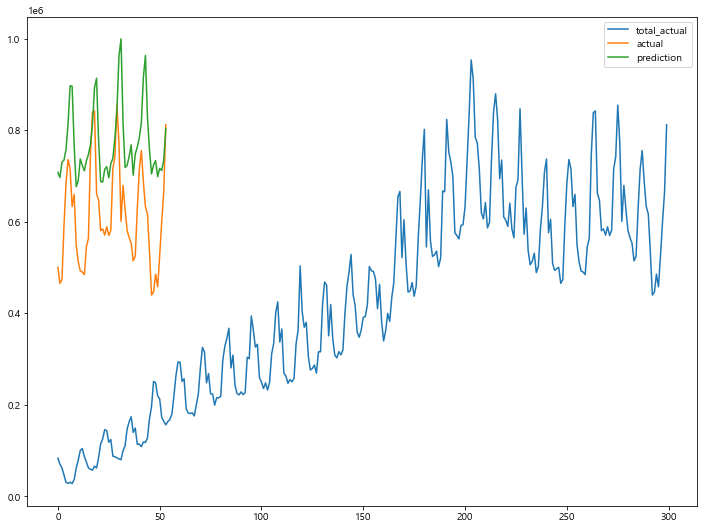

In [298]:
plt.figure(figsize=(12, 9))
plt.plot(target_i, label = 'total_actual')
plt.plot(y_test, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

=================================

In [299]:
# data ,target 데이터 불러오기
data = pd.read_csv('./data_final.csv',index_col=0)
target = pd.read_csv('./target.csv')

# 민수용, 산업용
target_c = target['CIVIL']
target_i = target['IND']

# df 생성
df = pd.concat([data,target_c], axis=1)

In [300]:
df.columns

Index(['YEAR', 'AT', 'LT', 'HT', 'CAP_TEMP_EF', 'DONGNAM_TEMP_EF',
       'DAEGYUNG_TEMP_EF', 'CHOONG_TEMP_EF', 'HONAM_TEMP_EF', 'MEAN_TEMP_EF',
       'POWER_WATER', 'POWER_FIRE', 'POWER_NUCLEAR', 'POWER_NAEYEON',
       'POWER_GROUP', 'POWER_TRANS', 'POWER_GAS', 'POWER_JUNG', 'POWER_MOO',
       'POWER_YOU', 'POWER_LNG', 'all', 'family', 'public', 'service',
       'civil_sum', 'argri_fishing', 'mining', 'manufact', 'ind_sum', 'CIVIL'],
      dtype='object')

In [302]:
from sklearn.preprocessing import MinMaxScaler

df.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['AT', 'LT', 'HT', 'CAP_TEMP_EF', 'DONGNAM_TEMP_EF',
       'DAEGYUNG_TEMP_EF', 'CHOONG_TEMP_EF', 'HONAM_TEMP_EF', 'MEAN_TEMP_EF',
       'POWER_WATER', 'POWER_FIRE', 'POWER_NUCLEAR', 'POWER_NAEYEON',
       'POWER_GROUP', 'POWER_TRANS', 'POWER_GAS', 'POWER_JUNG', 'POWER_MOO',
       'POWER_YOU', 'POWER_LNG', 'all', 'family', 'public', 'service',
       'civil_sum', 'argri_fishing', 'mining', 'manufact', 'ind_sum','CIVIL']
df_scaled = scaler.fit_transform(df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,AT,LT,HT,CAP_TEMP_EF,DONGNAM_TEMP_EF,DAEGYUNG_TEMP_EF,CHOONG_TEMP_EF,HONAM_TEMP_EF,MEAN_TEMP_EF,POWER_WATER,...,all,family,public,service,civil_sum,argri_fishing,mining,manufact,ind_sum,CIVIL
0,0.119401,0.211867,0.059217,0.962362,0.843924,0.842862,0.836159,0.803336,0.897574,0.165935,...,0.025200,0.047550,0.022943,0.024189,0.032655,0.008191,0.089819,0.057683,0.049688,0.244088
1,0.120178,0.202764,0.092605,0.944191,0.823706,0.826438,0.819845,0.785243,0.879284,0.159738,...,0.000000,0.043302,0.023558,0.018796,0.027925,0.024838,0.038433,0.005028,0.002813,0.225357
2,0.154554,0.246586,0.091354,0.829553,0.614455,0.630423,0.613482,0.569850,0.717359,0.165656,...,0.021377,0.004930,0.008597,0.000659,0.002479,0.036284,0.097338,0.084134,0.076453,0.182918
3,0.187260,0.264731,0.145515,0.626857,0.378784,0.409702,0.337924,0.270990,0.482756,0.169633,...,0.026404,0.017129,0.021931,0.008748,0.012953,0.002014,0.111380,0.085734,0.074844,0.116152
4,0.231290,0.316306,0.172376,0.280936,0.298854,0.329730,0.236877,0.177441,0.256523,0.235305,...,0.019440,0.000000,0.000000,0.000681,0.000000,0.008902,0.092618,0.085744,0.075281,0.042906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1.000000,1.000000,0.996179,0.205006,0.031211,0.031220,0.027430,0.023181,0.105861,0.803492,...,0.855630,0.764281,0.800154,0.800842,0.839172,0.737714,0.247074,0.856790,0.846251,0.145237
296,0.810567,0.750738,0.836423,0.227114,0.180772,0.287526,0.149389,0.123916,0.189422,0.629421,...,0.870602,0.841891,0.740578,0.761076,0.832501,0.803953,0.315869,0.891687,0.885004,0.136431
297,0.604894,0.521640,0.643739,0.411108,0.294644,0.425918,0.316760,0.227973,0.350950,0.265176,...,0.693669,0.505635,0.588249,0.590748,0.600022,0.564597,0.303253,0.806613,0.785020,0.249422
298,0.421387,0.351787,0.532630,0.621352,0.429899,0.555267,0.482347,0.366024,0.532280,0.221027,...,0.754595,0.542281,0.698444,0.636553,0.652586,0.832913,0.484946,0.849131,0.851057,0.477397


In [303]:
TEST_SIZE = 60
WINDOW_SIZE = 6

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [304]:
def make_dataset(data, label, window_size=6):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [305]:
from sklearn.model_selection import train_test_split

feature_cols = ['AT', 'LT', 'HT', 'CAP_TEMP_EF', 'DONGNAM_TEMP_EF',
       'DAEGYUNG_TEMP_EF', 'CHOONG_TEMP_EF', 'HONAM_TEMP_EF', 'MEAN_TEMP_EF',
       'POWER_WATER', 'POWER_FIRE', 'POWER_NUCLEAR', 'POWER_NAEYEON',
       'POWER_GROUP', 'POWER_TRANS', 'POWER_GAS', 'POWER_JUNG', 'POWER_MOO',
       'POWER_YOU', 'POWER_LNG', 'all', 'family', 'public', 'service',
       'civil_sum', 'argri_fishing', 'mining', 'manufact', 'ind_sum']
label_cols = ['CIVIL']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 6)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape


((187, 6, 29), (47, 6, 29))

In [306]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((60, 29), (60, 1))

In [307]:
test_feature, test_label = make_dataset(test_feature, test_label, 6)
test_feature.shape, test_label.shape

((54, 6, 29), (54, 1))

In [308]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [309]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# model_path = 'model'
# filename = os.path.join(model_path, 'tmp_checkpoint.h5')
# checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop])

Epoch 1/200
12/12 [==============================] - 1s 16ms/step - loss: 0.1332 - val_loss: 0.0771
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 0.0773 - val_loss: 0.0637
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 0.0598 - val_loss: 0.0604
Epoch 4/200
12/12 [==============================] - 0s 6ms/step - loss: 0.0499 - val_loss: 0.0515
Epoch 5/200
12/12 [==============================] - 0s 6ms/step - loss: 0.0430 - val_loss: 0.0458
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.0359 - val_loss: 0.0389
Epoch 7/200
12/12 [==============================] - 0s 5ms/step - loss: 0.0304 - val_loss: 0.0331
Epoch 8/200
12/12 [==============================] - 0s 5ms/step - loss: 0.0245 - val_loss: 0.0272
Epoch 9/200
12/12 [==============================] - 0s 6ms/step - loss: 0.0194 - val_loss: 0.0211
Epoch 10/200
12/12 [==============================] - 0s 5ms/step - loss: 0.0154 - val_loss: 0.0176
Epoch 11

In [310]:
pred = model.predict(test_feature)

pred.shape

2/2 [==============================] - 0s 4ms/step


(54, 1)

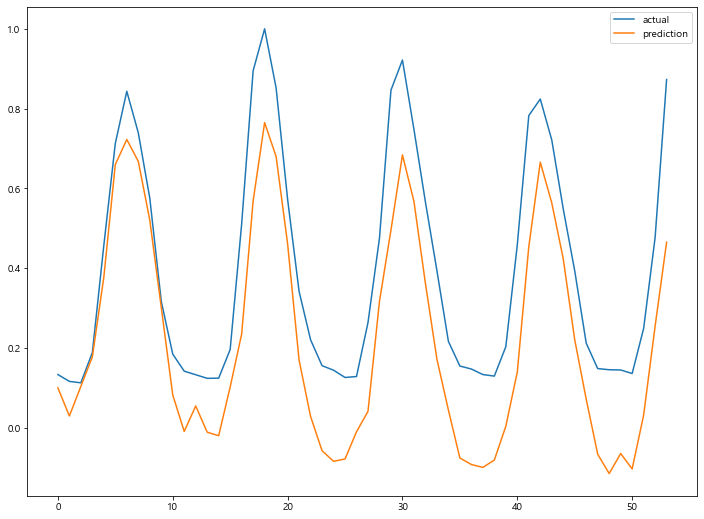

In [311]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()